# pymo 테스트 코드

In [7]:
# Read BVH Files
from pymo.parsers import BVHParser

parser = BVHParser()

bvh_file_path = '/home/maeng/In-HARD/Online/Skeleton/P01_R01.bvh'  # <-- 원본 .bvh 파일 경로를 입력하세요

parsed_data = parser.parse(bvh_file_path)

In [8]:
# Get Skeleton Info
from pymo.viz_tools import *

print_skel(parsed_data)

- Hips (None)
| | - Spine (Hips)
| | - Spine1 (Spine)
| | - Spine2 (Spine1)
| | - Spine3 (Spine2)
| | | | - LeftShoulder (Spine3)
| | | | - LeftArm (LeftShoulder)
| | | | - LeftForeArm (LeftArm)
| | | | - LeftHand (LeftForeArm)
| | | | | | | | - LeftInHandPinky (LeftHand)
| | | | | | | | - LeftHandPinky1 (LeftInHandPinky)
| | | | | | | | - LeftHandPinky2 (LeftHandPinky1)
| | | | | | | | - LeftHandPinky3 (LeftHandPinky2)
| | | | | | | | - LeftHandPinky3_Nub (LeftHandPinky3)
| | | | | | | - LeftInHandRing (LeftHand)
| | | | | | | - LeftHandRing1 (LeftInHandRing)
| | | | | | | - LeftHandRing2 (LeftHandRing1)
| | | | | | | - LeftHandRing3 (LeftHandRing2)
| | | | | | | - LeftHandRing3_Nub (LeftHandRing3)
| | | | | | - LeftInHandMiddle (LeftHand)
| | | | | | - LeftHandMiddle1 (LeftInHandMiddle)
| | | | | | - LeftHandMiddle2 (LeftHandMiddle1)
| | | | | | - LeftHandMiddle3 (LeftHandMiddle2)
| | | | | | - LeftHandMiddle3_Nub (LeftHandMiddle3)
| | | | | - LeftInHandIndex (LeftHand)
| | | | | - L

In [9]:
# scikit-learn Pipeline API
from pymo.preprocessing import *
from sklearn.pipeline import Pipeline

data_pipe = Pipeline([
    ('param', MocapParameterizer('position')),
    ('rcpn', RootCentricPositionNormalizer()),
    ('delta', RootTransformer('abdolute_translation_deltas')),
    ('const', ConstantsRemover()),
    ('np', Numpyfier()),
    ('down', DownSampler(2)),
    ('stdscale', ListStandardScaler())
])

piped_data = data_pipe.fit_transform([parsed_data])

/home/maeng/miniconda3/envs/In-HARD/lib/python3.10/site-packages/pymo/preprocessing.py:146: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pos_df['%s_Yposition'%joint] = pd.Series(data=[e[1] for e in tree_data[joint][1]], index=pos_df.index)
/home/maeng/miniconda3/envs/In-HARD/lib/python3.10/site-packages/pymo/preprocessing.py:147: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pos_df['%s_Zposition'%joint] = pd.Series(data=[e[2] for e in tree_data[joint][1]], index=pos_df.index)
/home/maeng/miniconda3/envs/In-HARD/lib/python3.10/s

In [10]:
# Convert to Positions
mp = MocapParameterizer('position')

positions = mp.fit_transform([parsed_data])

/home/maeng/miniconda3/envs/In-HARD/lib/python3.10/site-packages/pymo/preprocessing.py:146: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pos_df['%s_Yposition'%joint] = pd.Series(data=[e[1] for e in tree_data[joint][1]], index=pos_df.index)
/home/maeng/miniconda3/envs/In-HARD/lib/python3.10/site-packages/pymo/preprocessing.py:147: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pos_df['%s_Zposition'%joint] = pd.Series(data=[e[2] for e in tree_data[joint][1]], index=pos_df.index)
/home/maeng/miniconda3/envs/In-HARD/lib/python3.10/s

<Axes: >

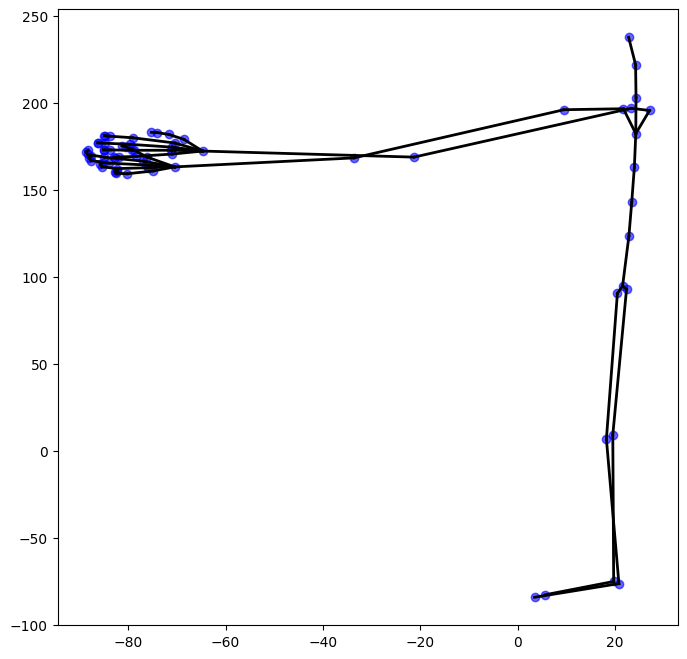

In [11]:
# Visualize a single 2D Frame
draw_stickfigure(positions[0], frame=10)

In [12]:
# Animate in 3D (inside a Jupyter Notebook)
nb_play_mocap(positions[0], 'pos', 
              scale=2, camera_z=800, frame_time=1/120, 
              base_url='pymo/mocapplayer/playBuffer.html')

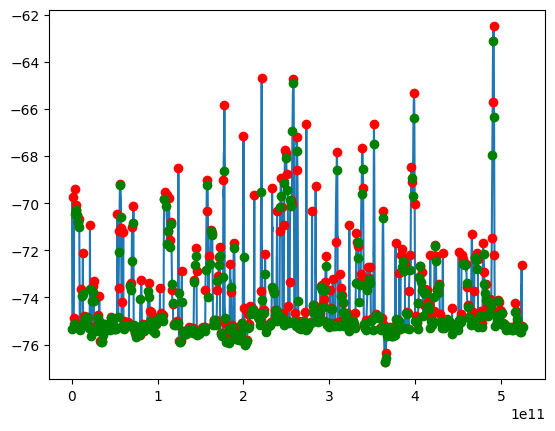

In [16]:
# Foot/Ground Contact Detector
from pymo.features import *

plot_foot_up_down(positions[0], 'RightFoot_Yposition')

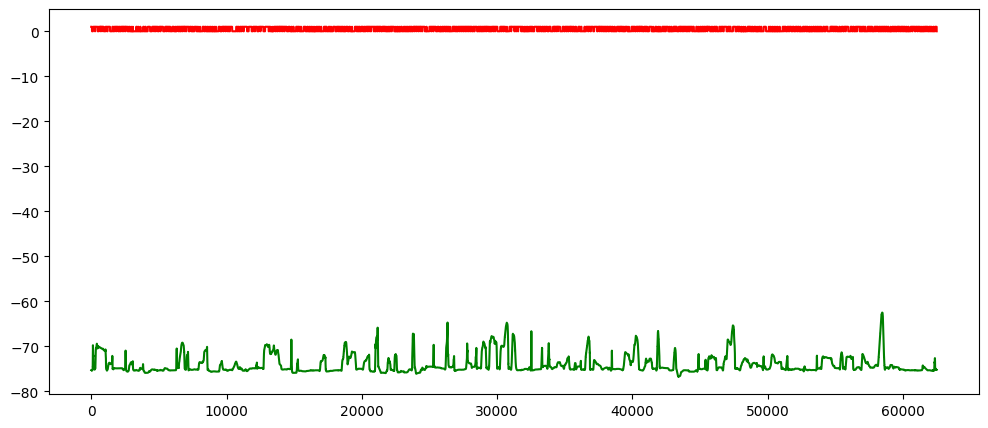

In [17]:
signal = create_foot_contact_signal(positions[0], 'RightFoot_Yposition')
plt.figure(figsize=(12,5))
plt.plot(signal, 'r')
plt.plot(positions[0].values['RightFoot_Yposition'].values, 'g')

# 지희님 work-flow follow-up

In [18]:
from pymo.parsers import BVHParser
from pymo.preprocessing import MocapParameterizer
import numpy as np
import os

In [19]:
# 1. BVH 파일 파싱
bvh_file_path = '/home/maeng/In-HARD/Online/Skeleton/P01_R03.bvh'  # <-- 원본 .bvh 파일 경로를 입력하세요
parser = BVHParser()

try:
    parsed_data = parser.parse(bvh_file_path)
except FileNotFoundError:
    print(f"오류: '{bvh_file_path}' 파일을 찾을 수 없습니다. 파일 경로를 확인해주세요.")
    raise

In [20]:
# 2. 절대 좌표(Global Position) 계산 파이프라인 생성
# 'position' 파라미터를 사용하면 pymo가 알아서 Forward Kinematics를 수행합니다.
mp = MocapParameterizer('position')

# 3. 파이프라인을 통해 데이터 변환
# 이 과정에서 모든 관절의 월드 좌표가 계산됩니다.
global_positions = mp.fit_transform([parsed_data])[0]

/home/maeng/miniconda3/envs/In-HARD/lib/python3.10/site-packages/pymo/preprocessing.py:146: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pos_df['%s_Yposition'%joint] = pd.Series(data=[e[1] for e in tree_data[joint][1]], index=pos_df.index)
/home/maeng/miniconda3/envs/In-HARD/lib/python3.10/site-packages/pymo/preprocessing.py:147: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pos_df['%s_Zposition'%joint] = pd.Series(data=[e[2] for e in tree_data[joint][1]], index=pos_df.index)
/home/maeng/miniconda3/envs/In-HARD/lib/python3.10/s

In [21]:
# 4. 결과 확인
print("="*30)
print("절대 좌표 데이터 정보")
print("="*30)
# global_positions.values 는 (프레임 수, 총 좌표 수) 형태의 Numpy 배열입니다.
# 총 좌표 수 = 관절 수 * 3 (X, Y, Z)
print(f"데이터 형태 (Frames, Dims): {global_positions.values.shape}")

# 관절 순서 확인 (데이터가 어떤 순서로 되어 있는지)
joint_names = global_positions.skeleton.keys()
print(f"\n관절 수: {len(joint_names)}")
print(f"관절 순서: {list(joint_names)}")

절대 좌표 데이터 정보
데이터 형태 (Frames, Dims): (50244, 216)

관절 수: 72
관절 순서: ['Hips', 'RightUpLeg', 'RightLeg', 'RightFoot', 'RightFoot_Nub', 'LeftUpLeg', 'LeftLeg', 'LeftFoot', 'LeftFoot_Nub', 'Spine', 'Spine1', 'Spine2', 'Spine3', 'Neck', 'Head', 'Head_Nub', 'RightShoulder', 'RightArm', 'RightForeArm', 'RightHand', 'RightHandThumb1', 'RightHandThumb2', 'RightHandThumb3', 'RightHandThumb3_Nub', 'RightInHandIndex', 'RightHandIndex1', 'RightHandIndex2', 'RightHandIndex3', 'RightHandIndex3_Nub', 'RightInHandMiddle', 'RightHandMiddle1', 'RightHandMiddle2', 'RightHandMiddle3', 'RightHandMiddle3_Nub', 'RightInHandRing', 'RightHandRing1', 'RightHandRing2', 'RightHandRing3', 'RightHandRing3_Nub', 'RightInHandPinky', 'RightHandPinky1', 'RightHandPinky2', 'RightHandPinky3', 'RightHandPinky3_Nub', 'LeftShoulder', 'LeftArm', 'LeftForeArm', 'LeftHand', 'LeftHandThumb1', 'LeftHandThumb2', 'LeftHandThumb3', 'LeftHandThumb3_Nub', 'LeftInHandIndex', 'LeftHandIndex1', 'LeftHandIndex2', 'LeftHandIndex3', 'LeftHand

In [22]:
# 5. 첫 번째 프레임의 데이터 일부 출력
print("\n--- 첫 번째 프레임(Frame 0)의 절대 좌표 (일부) ---")
frame_0_data = global_positions.values.iloc[0, :]

# 관절 이름과 해당 관절의 X, Y, Z 좌표를 짝지어 출력
for i, joint_name in enumerate(list(joint_names)[:5]): # 앞 5개 관절만 예시로 출력
    start_index = i * 3
    end_index = start_index + 3
    coords = frame_0_data[start_index:end_index]
    print(f"- {joint_name:<15}: X={coords[0]:.2f}, Y={coords[1]:.2f}, Z={coords[2]:.2f}")

# 이제 `global_positions.values` Numpy 배열을
# 딥러닝 모델 학습, 데이터 분석, 시각화 등 원하는 작업에 바로 사용하시면 됩니다.


--- 첫 번째 프레임(Frame 0)의 절대 좌표 (일부) ---
- Hips           : X=2.09, Y=94.62, Z=-0.32
- RightUpLeg     : X=8.32, Y=122.54, Z=0.29
- RightLeg       : X=10.72, Y=141.84, Z=0.24
- RightFoot      : X=12.67, Y=161.98, Z=-0.12
- RightFoot_Nub  : X=13.53, Y=181.38, Z=-0.92


In [14]:
len(joint_names)

72

In [15]:
joint_names

dict_keys(['Hips', 'RightUpLeg', 'RightLeg', 'RightFoot', 'RightFoot_Nub', 'LeftUpLeg', 'LeftLeg', 'LeftFoot', 'LeftFoot_Nub', 'Spine', 'Spine1', 'Spine2', 'Spine3', 'Neck', 'Head', 'Head_Nub', 'RightShoulder', 'RightArm', 'RightForeArm', 'RightHand', 'RightHandThumb1', 'RightHandThumb2', 'RightHandThumb3', 'RightHandThumb3_Nub', 'RightInHandIndex', 'RightHandIndex1', 'RightHandIndex2', 'RightHandIndex3', 'RightHandIndex3_Nub', 'RightInHandMiddle', 'RightHandMiddle1', 'RightHandMiddle2', 'RightHandMiddle3', 'RightHandMiddle3_Nub', 'RightInHandRing', 'RightHandRing1', 'RightHandRing2', 'RightHandRing3', 'RightHandRing3_Nub', 'RightInHandPinky', 'RightHandPinky1', 'RightHandPinky2', 'RightHandPinky3', 'RightHandPinky3_Nub', 'LeftShoulder', 'LeftArm', 'LeftForeArm', 'LeftHand', 'LeftHandThumb1', 'LeftHandThumb2', 'LeftHandThumb3', 'LeftHandThumb3_Nub', 'LeftInHandIndex', 'LeftHandIndex1', 'LeftHandIndex2', 'LeftHandIndex3', 'LeftHandIndex3_Nub', 'LeftInHandMiddle', 'LeftHandMiddle1', 'Lef